In [1]:
import pandas as pd
import re 

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import scipy.sparse

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
# !pip install pyLDAvis

In [3]:
ori_df = pd.read_csv('../Data Scraping/Raw Data/train_dataset_all.csv')

ori_df = ori_df.dropna()

print(ori_df.shape)
ori_df.head()

df = ori_df.sample(n=5000, random_state=999)
print(df.shape)

(78099, 16)
(5000, 16)


In [4]:
# Convert to list
data = df.review.values.tolist()


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [5]:
# # Let's start with 2 topics.
# lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
# lda_model.print_topics()

In [6]:
# Convert to list
data = df.review.values.tolist()
data[:5]
# Remove @mentions 


['Yep, this is comfort food I do believe.  I fried the bacon til CRISP but not burned.  I added not butter as I felt the fat from the pig was enough.  Used curly egg noodles.  Plenty left over for lunch.  Thanks Mr. Hixson.',
 'Oh girl this is a keeper!  I skipped the walnuts and the flour, and used an egg white and sugar substitute.  Topped with sugar free syrup.  Awesome awesome!',
 'I used fat free cottage cheese & granola. Wonderful!',
 'This is a easy side dish that looks as good as it tastes.  I made it with a red pepper and together with the green onions, it was very festive!',
 'I was looking for a different way to jazz up plain canned green beans.  Some of the other reviewers said these beans were "tangy", so I used only half the amount of mustard and worcestershire sauce.  I didn\'t marinate them as long as stated because I was in a hurry, but we really enjoyed them! Thanks LonghornMama!']

# remove stopwords 

In [7]:
# Remove urls (remove a word starting with http)
# data = [re.sub(r'@\w+', '', sent) for sent in data]
# data = [re.sub(r'http\S+', '', sent) for sent in data]

nltk.download('punkt')
nltk.download('stopwords')

# set stop words
stop_words = stopwords.words('english')

stop_words.extend([ 'bit', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'lot', 'lack', 'make', 'di', 'havena', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'from', 'subject', 're', 'edu', 'use', 'amp', 'een', 'ia', 'es', 'ich', 'das', 'ita', 'ich', 'das', 'der', 'aŒ'])


newdata = []
for sent in data:
    # tokenize
    tokenized_review = word_tokenize(sent)
    # standardize to lower case
    lower_review = [w.lower() for w in tokenized_review]
    # keep token words which are text
    text_words_only = [w for w in lower_review if re.search('^[a-z]+$',w)]
    text_stopremoved = [w for w in text_words_only if w not in stop_words]
    text_joined = " ".join(text_stopremoved)
    newdata.append(text_joined)

newdata[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['yep comfort food believe fried bacon til crisp burned added butter felt fat pig enough used curly egg noodles plenty left lunch thanks hixson',
 'oh girl keeper skipped walnuts flour used egg white sugar substitute topped sugar free syrup awesome awesome',
 'used fat free cottage cheese granola wonderful',
 'easy side dish looks tastes made red pepper together green onions festive',
 'looking different way jazz plain canned green beans reviewers said beans tangy used half amount mustard worcestershire sauce marinate long stated hurry really enjoyed thanks longhornmama']

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(newdata))

print(data_words[:1])

[['yep', 'comfort', 'food', 'believe', 'fried', 'bacon', 'til', 'crisp', 'burned', 'added', 'butter', 'felt', 'fat', 'pig', 'enough', 'used', 'curly', 'egg', 'noodles', 'plenty', 'left', 'lunch', 'thanks', 'hixson']]


In [9]:
# Build the bigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)


In [10]:
def lemmatization(texts, allowed_postags=['NOUN']):
    """"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component
# For normal use
# !python -m spacy download en_core_web_sm
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# For Colab use
import en_core_web_sm
nlp = en_core_web_sm.load()

print("Before Lemmatization:", data_words_bigrams[:1])

# Do lemmatization keeping only noun
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'PROPN',"ADJ"])

print("After Lemmatization: ", data_lemmatized[:1])


Before Lemmatization: [['yep', 'comfort_food', 'believe', 'fried', 'bacon', 'til', 'crisp', 'burned', 'added', 'butter', 'felt', 'fat', 'pig', 'enough', 'used', 'curly', 'egg_noodles', 'plenty', 'left', 'lunch', 'thanks', 'hixson']]
After Lemmatization:  [['comfort_food', 'bacon', 'crisp', 'butter', 'fat', 'pig', 'curly', 'egg_noodle', 'lunch', 'thank', 'hixson']]


# remove stop words again because after lematizing there may be shortened junk words that dont make sense

In [11]:
# Remove urls (remove a word starting with http)
data = [re.sub(r'@\w+', '', sent) for sent in data]
data = [re.sub(r'http\S+', '', sent) for sent in data]

nltk.download('punkt')
nltk.download('stopwords')

# set stop words
stop_words = stopwords.words('english')
stop_words.extend(["thank","thanks","great","way","dh","wonderful"])
stop_words.extend(['thank', 'bit', 'recipe', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'lot', 'lack', 'make', 'di', 'havena', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'from', 'subject', 're', 'edu', 'use', 'amp', 'een', 'ia', 'es', 'ich', 'das', 'ita', 'ich', 'das', 'der', 'aŒ'])


newdata = []
for data_sent in data_lemmatized:

    text_stopremoved = [w for w in data_sent if w not in stop_words]
    newdata.append(text_stopremoved)
# newdata[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(newdata)
id2word.filter_extremes(no_below=1.5, no_above=0.8) # this will filter out words that are less frequen

# Create Corpus
texts = newdata

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [13]:
print(id2word[0], id2word[1], id2word[2], id2word[3], id2word[4])


bacon butter comfort_food crisp curly


# adjust the number of models here

In [14]:
# Build LDA model

lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10)
lda_model.print_topics()

[(0,
  '0.019*"dessert" + 0.019*"simple" + 0.015*"flavour" + 0.014*"egg" + 0.012*"fruit" + 0.011*"tasty" + 0.011*"light" + 0.010*"easy" + 0.010*"delicious" + 0.009*"pudding"'),
 (1,
  '0.027*"dish" + 0.026*"chicken" + 0.018*"delicious" + 0.014*"sauce" + 0.010*"flavor" + 0.009*"onion" + 0.009*"time" + 0.009*"fresh" + 0.008*"simple" + 0.008*"minute"'),
 (2,
  '0.010*"daughter" + 0.010*"cinnamon" + 0.009*"banana" + 0.009*"delicious" + 0.009*"vanilla" + 0.009*"morning" + 0.008*"coconut" + 0.008*"love" + 0.008*"flavor" + 0.008*"yogurt"'),
 (3,
  '0.025*"sauce" + 0.015*"rice" + 0.012*"chicken" + 0.011*"potato" + 0.010*"time" + 0.010*"amount" + 0.010*"yummy" + 0.009*"next_time" + 0.008*"half" + 0.008*"hot"'),
 (4,
  '0.031*"flavor" + 0.018*"fresh" + 0.018*"little" + 0.013*"taste" + 0.010*"sweet" + 0.010*"lemon" + 0.009*"delicious" + 0.008*"sugar" + 0.007*"garlic" + 0.007*"milk"'),
 (5,
  '0.021*"cheese" + 0.018*"bread" + 0.016*"easy" + 0.011*"excellent" + 0.011*"cake" + 0.010*"breakfast" + 0.

# coherence score of 0.5 is the best the lower the perplexity score the better

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=newdata, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.572261213006666

Coherence Score:  0.3143342527113055


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.056994  0.072998       1        1  12.177355
1     -0.087295  0.108694       2        1  11.695819
6     -0.128640  0.109565       3        1  10.996794
7      0.043546  0.067488       4        1  10.877002
4      0.036244  0.037387       5        1  10.874970
5      0.058373 -0.022567       6        1  10.616466
8      0.238361  0.056334       7        1  10.484844
0      0.014575 -0.229196       8        1   7.824960
9     -0.157632 -0.114664       9        1   7.678978
2      0.039463 -0.086039      10        1   6.772811, topic_info=        Term        Freq       Total Category  logprob  loglift
72      soup  266.000000  266.000000  Default  30.0000  30.0000
424   cookie  210.000000  210.000000  Default  29.0000  29.0000
97   chicken  479.000000  479.000000  Default  28.0000  28.0000
11     flour  205.000000  205.000000  Default  27.0000  27.0000
693   tomato  202.000000  202.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
652     dish   29.765297  485.278065  Topic10  -5.0373  -0.0991
450      hot   24.853723  169.938327  Topic10  -5.2176   0.7698
200   change   25.473071  209.595465  Topic10  -5.1930   0.5847
669      day   25.000087  226.214793  Topic10  -5.2118   0.4896
203    sauce   25.636812  556.496025  Topic10  -5.1866  -0.3854

[739 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1563      9  0.880658       abit
2698      2  0.967355     actual
1186      4  0.917733  addictive
1200      2  0.097600   addition
1200      3  0.156160   addition
...     ...       ...        ...
1545      2  0.155589   zucchini
1545      5  0.140030   zucchini
1545      7  0.077794   zucchini
1545      8  0.015559   zucchini
1545     10  0.093353   zucchini

[1682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 7, 8, 5, 6, 9, 1, 10, 3])

In [17]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'topic_perc_contrib', 'keywords']
    
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.head()


,dominant_topic,topic_perc_contrib,keywords
0,6.0,0.4753,"soup, onion, little, chicken, tasty, dish, sal..."
1,2.0,0.4335,"daughter, cinnamon, banana, delicious, vanilla..."
2,2.0,0.7750,"daughter, cinnamon, banana, delicious, vanilla..."
3,6.0,0.8714,"soup, onion, little, chicken, tasty, dish, sal..."
4,3.0,0.3818,"sauce, rice, chicken, potato, time, amount, yu..."


# wordcloud

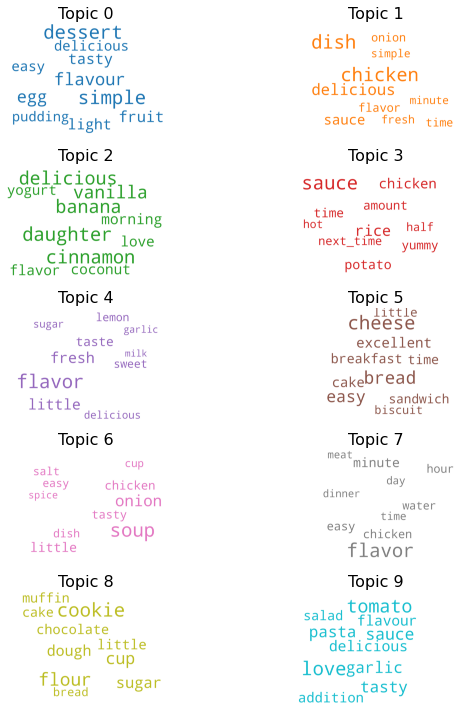

In [18]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

# adjust number of plots here
fig, axes = plt.subplots(5,2, figsize=(10,10), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)

    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [19]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([sent_topics_sorteddf_lda, 
                                             grp.sort_values(['topic_perc_contrib'], ascending=[0]).head(3)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# # Show
sent_topics_sorteddf_lda

,dominant_topic,topic_perc_contrib,keywords
0,0.0,0.9667,"dessert, simple, flavour, egg, fruit, tasty, l..."
1,0.0,0.9526,"dessert, simple, flavour, egg, fruit, tasty, l..."
2,0.0,0.9437,"dessert, simple, flavour, egg, fruit, tasty, l..."
3,1.0,0.9591,"dish, chicken, delicious, sauce, flavor, onion..."
4,1.0,0.9470,"dish, chicken, delicious, sauce, flavor, onion..."
5,1.0,0.9437,"dish, chicken, delicious, sauce, flavor, onion..."
6,2.0,0.9550,"daughter, cinnamon, banana, delicious, vanilla..."
7,2.0,0.9500,"daughter, cinnamon, banana, delicious, vanilla..."
8,2.0,0.9470,"daughter, cinnamon, banana, delicious, vanilla..."
9,3.0,0.9769,"sauce, rice, chicken, potato, time, amount, yu..."


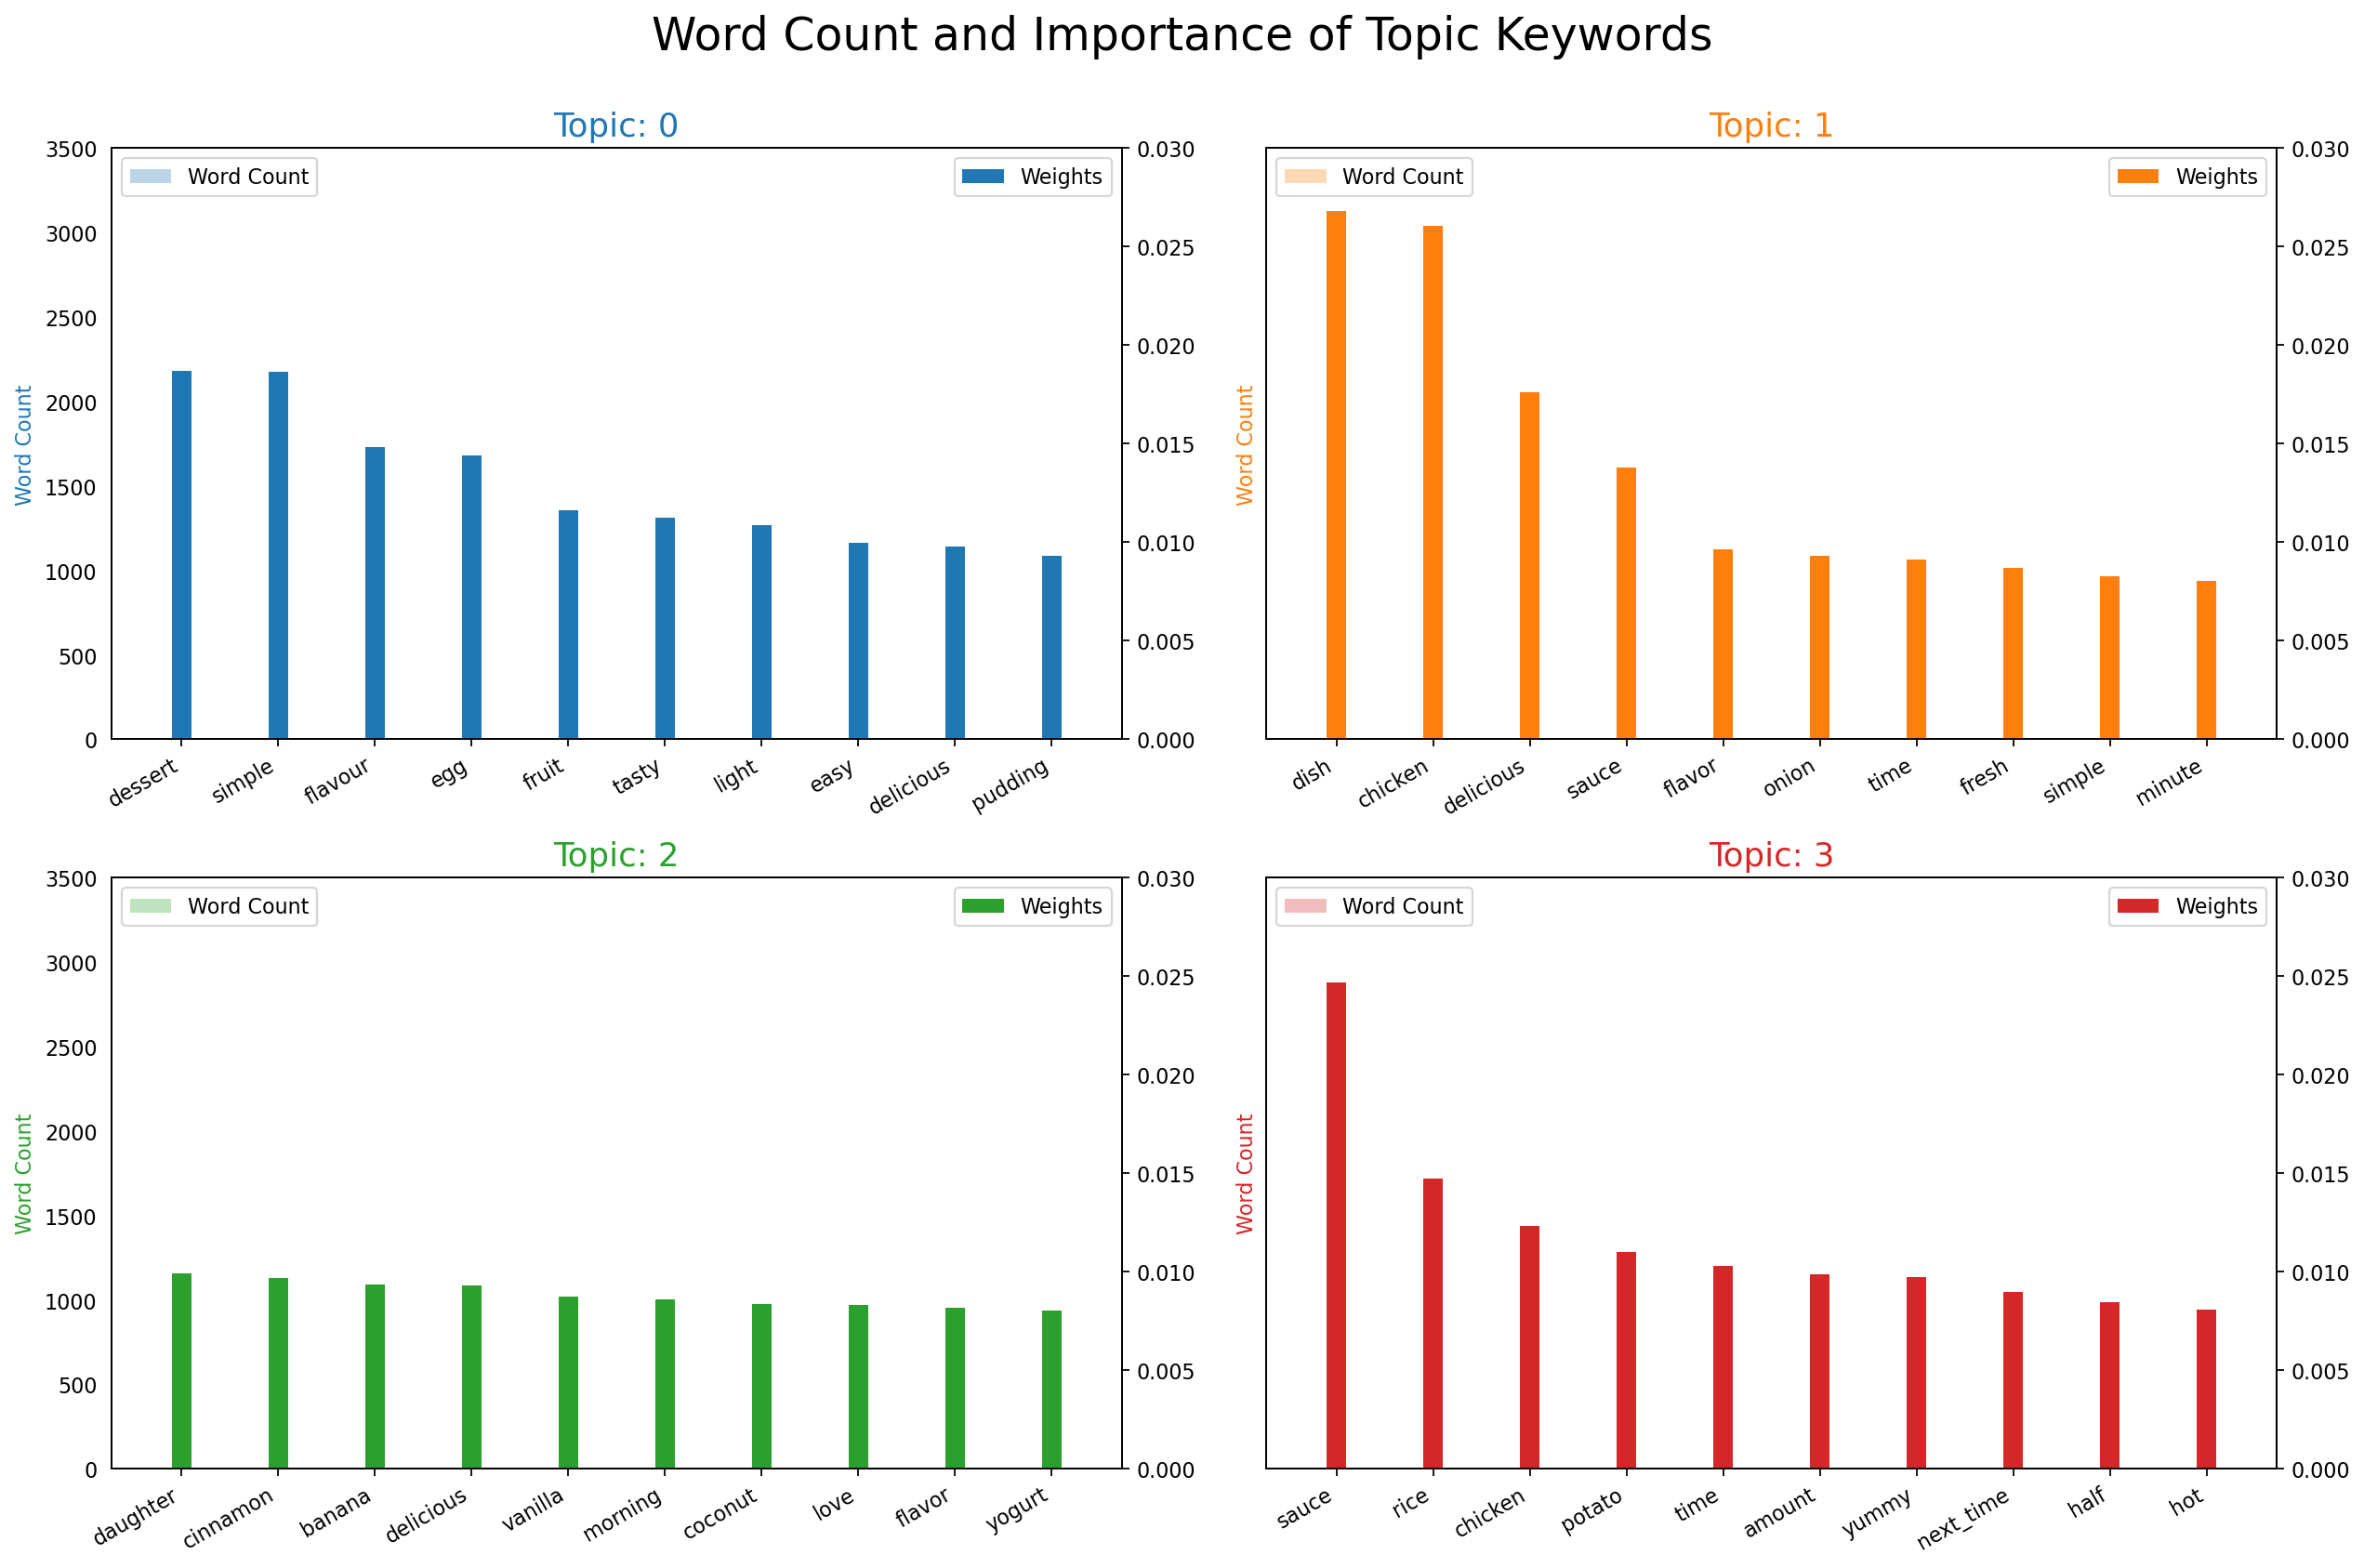

In [20]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in df for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [21]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
     
    topic_weights.append([w for w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2624 samples in 0.002s...
[t-SNE] Computed neighbors for 2624 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2624
[t-SNE] Computed conditional probabilities for sample 2000 / 2624
[t-SNE] Computed conditional probabilities for sample 2624 / 2624
[t-SNE] Mean sigma: 0.010822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.042698
[t-SNE] KL divergence after 1000 iterations: 0.208985


Loading BokehJS ...